# Building an OIS Curve with Meeting Dates

We build an OIS curve from OIS swaps that include forward starting OIS using MM dates.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from financepy.utils import *
from financepy.products.rates import *

####################################################################
#  FINANCEPY BETA Version 0.350 - This build: 30 Apr 2024 at 22:32 #
#     This software is distributed FREE AND WITHOUT ANY WARRANTY   #
#  Report bugs as issues at https://github.com/domokane/FinancePy  #
####################################################################



In [3]:
value_dt = Date(18, 9, 2019)

Set up meeting dates

In [4]:
m1Date = Date(23, 11, 2019)
m2Date = Date(20, 1, 2020)
m3Date = Date(18, 3, 2020)
m4Date = Date(20, 5, 2020)

## Building the OIS Curve

We construct the OIS curve from a series of swaps, some forward starting. The default assumption on the floating leg is annual payments.

In [5]:
depoDCCType = DayCountTypes.THIRTY_E_360_ISDA
depos = []
spot_days = 0
settle_dt = value_dt.add_weekdays(spot_days)

swaps = []
swap_type = SwapTypes.PAY
fixed_dcc_type = DayCountTypes.ACT_365F
fixed_freq_type = FrequencyTypes.ANNUAL

# This OIS stops at the next meeting date
swap = OIS(settle_dt, m1Date, swap_type, 0.0420, fixed_freq_type, fixed_dcc_type); swaps.append(swap)

# These OIS are forward starting and last between MM meeting dates
swap = OIS(m1Date, m2Date, swap_type, 0.0320, fixed_freq_type, fixed_dcc_type); swaps.append(swap)
swap = OIS(m2Date, m3Date, swap_type, 0.0520, fixed_freq_type, fixed_dcc_type); swaps.append(swap)
swap = OIS(m3Date, m4Date, swap_type, 0.0320, fixed_freq_type, fixed_dcc_type); swaps.append(swap)

# Standard OIS with standard annual terms
swap = OIS(settle_dt, "2Y", swap_type, 0.0330, fixed_freq_type, fixed_dcc_type); swaps.append(swap)
swap = OIS(settle_dt, "3Y", swap_type, 0.0350, fixed_freq_type, fixed_dcc_type); swaps.append(swap)
swap = OIS(settle_dt, "4Y", swap_type, 0.0375, fixed_freq_type, fixed_dcc_type); swaps.append(swap)
swap = OIS(settle_dt, "5Y", swap_type, 0.0400, fixed_freq_type, fixed_dcc_type); swaps.append(swap)
swap = OIS(settle_dt, "7Y", swap_type, 0.0420, fixed_freq_type, fixed_dcc_type); swaps.append(swap)
swap = OIS(settle_dt, "10Y", swap_type, 0.0430, fixed_freq_type, fixed_dcc_type); swaps.append(swap)

In [6]:
oisCurveFF = OISCurve(value_dt, [], [], swaps, InterpTypes.FLAT_FWD_RATES)

In [7]:
oisCurveLF = OISCurve(value_dt, [], [], swaps, InterpTypes.LINEAR_FWD_RATES)

In [8]:
oisCurveLZ = OISCurve(value_dt, [], [], swaps, InterpTypes.LINEAR_ZERO_RATES)

In [9]:
for swap in swaps:
    v_ff = swap.value(value_dt, oisCurveFF) / swap.fixed_leg.notional
    v_lf = swap.value(value_dt, oisCurveLF) / swap.fixed_leg.notional
    v_lz = swap.value(value_dt, oisCurveLZ) / swap.fixed_leg.notional
    print("%12s %12.8f %12.8f %12.8f" % (swap.maturity_dt, v_ff, v_lf, v_lz))

 25-NOV-2019   0.00000000   0.00000000   0.00000000
 20-JAN-2020  -0.00000000  -0.00000000  -0.00000000
 18-MAR-2020  -0.00000000  -0.00000000  -0.00000000
 20-MAY-2020  -0.00000000  -0.00000000  -0.00000000
 20-SEP-2021   0.00000000  -0.00000000   0.00000000
 19-SEP-2022  -0.00000000  -0.00000000   0.00000000
 18-SEP-2023  -0.00000000  -0.00000000  -0.00000000
 18-SEP-2024   0.00000000  -0.00000000   0.00000000
 18-SEP-2026  -0.00000000  -0.00000000  -0.00000000
 18-SEP-2029  -0.00000000  -0.00000000  -0.00000000


All of the swaps are repriced.

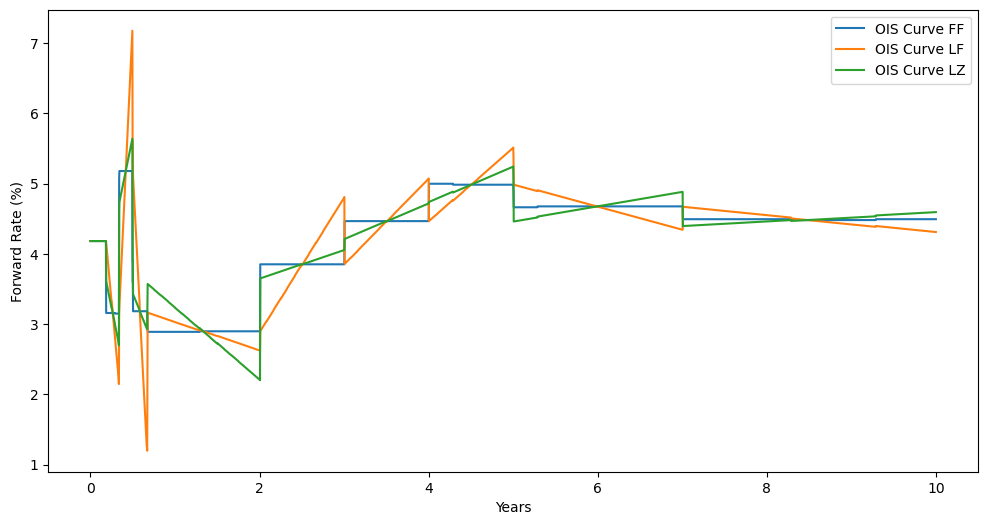

In [10]:
years = np.linspace(0, 10, 10*365)
dates = settle_dt.add_years(years)
oisCurveFwdsFF = oisCurveFF.fwd(dates)    
oisCurveFwdsLF = oisCurveLF.fwd(dates)    
oisCurveFwdsLZ = oisCurveLZ.fwd(dates)    

plt.figure(figsize=(12,6))
plt.plot(years, oisCurveFwdsFF*100.0, label="OIS Curve FF")
plt.plot(years, oisCurveFwdsLF*100.0, label="OIS Curve LF")
plt.plot(years, oisCurveFwdsLZ*100.0, label="OIS Curve LZ")
plt.xlabel("Years")
plt.ylabel("Forward Rate (%)")
plt.legend();

The different interpolation schemes have their own strengths and weaknesses.

In [11]:
for swap in swaps:
    s_ff = swap.swap_rate(settle_dt, oisCurveFF) 
    s_lf = swap.swap_rate(settle_dt, oisCurveLF) 
    s_lz = swap.swap_rate(settle_dt, oisCurveLZ) 
    print("%12s %12.6f %12.6f %12.6f" % (swap.termination_dt, s_ff*100, s_lf*100, s_lz*100))

 23-NOV-2019     4.200000     4.200000     4.200000
 20-JAN-2020     3.200000     3.200000     3.200000
 18-MAR-2020     5.200000     5.200000     5.200000
 20-MAY-2020     3.200000     3.200000     3.200000
 18-SEP-2021     3.300000     3.300000     3.300000
 18-SEP-2022     3.500000     3.500000     3.500000
 18-SEP-2023     3.750000     3.750000     3.750000
 18-SEP-2024     4.000000     4.000000     4.000000
 18-SEP-2026     4.200000     4.200000     4.200000
 18-SEP-2029     4.300000     4.300000     4.300000


In [12]:
swap = swaps[4]
Schedule(swap.effective_dt, swap.maturity_dt, fixed_freq_type)

OBJECT TYPE: Schedule
EFFECTIVE DATE: 18-SEP-2019
END DATE: 20-SEP-2021
FREQUENCY: FrequencyTypes.ANNUAL
CALENDAR: CalendarTypes.WEEKEND
BUSDAYRULE: BusDayAdjustTypes.FOLLOWING
DATEGENRULE: DateGenRuleTypes.BACKWARD
ADJUST TERM DATE: True
END OF MONTH: False

In [13]:
swap.print_fixed_leg_pv()

START DATE: 18-SEP-2019
MATURITY DATE: 20-SEP-2021
COUPON (%): 3.3000000000000003
FREQUENCY: FrequencyTypes.ANNUAL
DAY COUNT: DayCountTypes.ACT_365F

PAYMENTS VALUATION:
+---------+-------------+----------+------+----------+-------+----------+----------+
| PAY_NUM |    PAY_dt   | NOTIONAL | RATE |   PMNT   |   DF  |    PV    |  CUM_PV  |
+---------+-------------+----------+------+----------+-------+----------+----------+
|    1    | 18-SEP-2020 | 1000000  | 3.3  | 33090.41 | 0.963 | 31867.4  | 31867.4  |
|    2    | 20-SEP-2021 | 1000000  | 3.3  | 33180.82 | 0.937 | 31091.78 | 62959.18 |
+---------+-------------+----------+------+----------+-------+----------+----------+


In [14]:
for swap in swaps:
    s_ff = oisCurveFF.swap_rate(swap.effective_dt, swap.termination_dt, fixed_freq_type, fixed_dcc_type) 
    s_lf = oisCurveLF.swap_rate(swap.effective_dt, swap.termination_dt, fixed_freq_type, fixed_dcc_type) 
    s_lz = oisCurveLZ.swap_rate(swap.effective_dt, swap.termination_dt, fixed_freq_type, fixed_dcc_type) 
    print("%12s %12.6f %12.6f %12.6f" % (swap.maturity_dt, s_ff*100, s_lf*100, s_lz*100))

 25-NOV-2019     4.200000     4.200000     4.200000
 20-JAN-2020     3.200000     3.200000     3.200000
 18-MAR-2020     5.200000     5.200000     5.200000
 20-MAY-2020     3.200000     3.200000     3.200000
 20-SEP-2021     3.299673     3.299694     3.299727
 19-SEP-2022     3.499884     3.499902     3.499929
 18-SEP-2023     3.750000     3.750000     3.750000
 18-SEP-2024     4.000000     4.000000     4.000000
 18-SEP-2026     4.200000     4.200000     4.200000
 18-SEP-2029     4.300000     4.300000     4.300000


Copyright (c) Dominic O'Kane 2020